# EOSpec image analysis Python/iPythonNotebook code

- Python version 2.7.15 (Anaconda 64-bit)

- A minimal version of the Python image analysis script, ImgAna_minimum.py, is also available in the same repo. 

- Feel free to share and modify.

In [1]:
import sys
print sys.version

2.7.15 |Anaconda, Inc.| (default, Dec 10 2018, 21:57:18) [MSC v.1500 64 bit (AMD64)]


## - 00 - import libraries: MatPlotLib for handling images; NumPy for matrix manipulation

In [2]:
import matplotlib.pyplot as pp
import numpy as np
import math
import warnings

## - 01 - function for displaying images and making figures

In [3]:
# x_plt: numpy array of plot, datatype float
# marker: marker of 1D-plot
# x_max: range of gray-scale plot    
    
def fig_out( x_plt, fig_dpi=100, marker="k-", x_max=1.0 ):
    pp.figure( dpi=fig_dpi )
    
    if x_plt.ndim == 1:
        # make a 1D plot (use array index as x-coord)
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( x_plt, marker )
    
    elif x_plt.ndim == 2:
        if len( x_plt[0] ) == 3:
            # make three 1D plot (rgb channels, use array index as x-coord)
            pp.style.use( "seaborn-darkgrid" )
            pp.plot( x_plt[:,0], 'r-' )
            pp.plot( x_plt[:,1], 'g-' )
            pp.plot( x_plt[:,2], 'b-' )
        else:
            # make a 2D grayscale image, with color bar 
            pp.style.use( "seaborn-dark" )
            pp.imshow( x_plt, cmap="gray", vmin=0, vmax=x_max )
            pp.colorbar()
            pp.show()
    
    elif x_plt.ndim == 3:
        # make a 2D RGB image
        pp.style.use( "seaborn-dark" )
        pp.imshow( x_plt )
        pp.show()
    
    else:
        print "Input not recognized."
        ## Not raise an error because no other functions depend on the output of this function.

In Python, an image is represented by a 3D-numpy array.
For example, a simple image of:
red, green, blue, black
cyan, purple, yellow, white
can be written as the following:

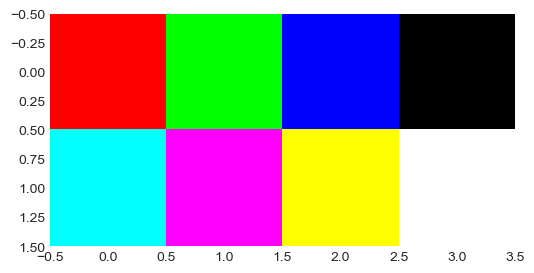

In [4]:
xi8 = np.array([[[255,0,0], [0,255,0], [0,0,255], [0,0,0]],
                [[0,255,255], [255,0,255], [255,255,0], [255,255,255]]])
fig_out( xi8, fig_dpi=100 )

- Pixel location matches the element location in the 2D-array x_img.
- Each pixel is an (r,g,b) pixel, with 8-bit (0-255) pixel depth.

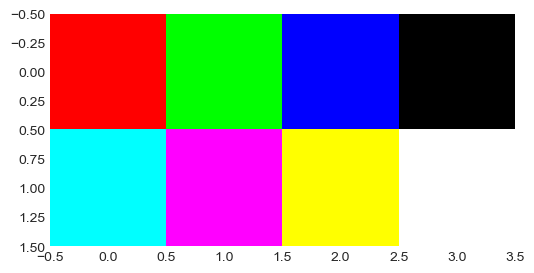

In [5]:
x8 = xi8.astype( float )/255.0
fig_out( x8, fig_dpi=100 )

- Each pixel is converted to float64 (from an 8-bit int)
- fig_out() function works the same

In [6]:
# example of an image from EOS 1
img_file = "EOSpec01/EOS_imgs/example_spec.jpg"
xi = pp.imread( img_file )
np.amax(xi)

255

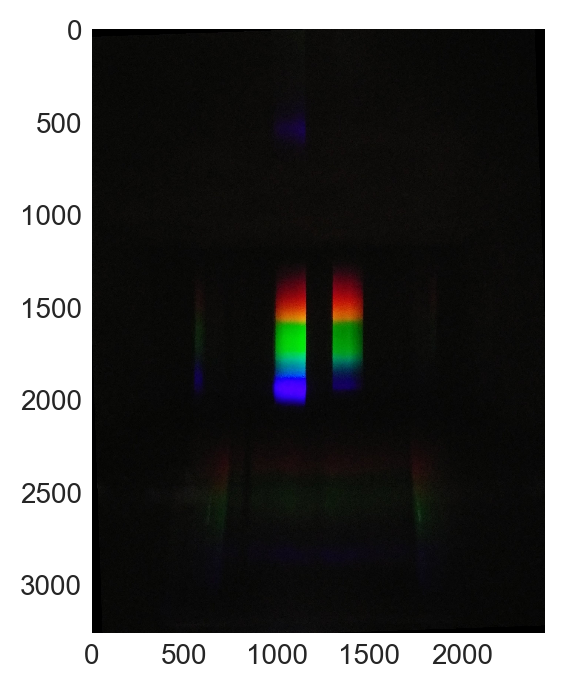

In [7]:
x_img = xi.astype( float )/255.0
fig_out( x_img, 200 )

In [8]:
np.shape(x_img)

(3264L, 2448L, 3L)

In [9]:
x_img.dtype

dtype('float64')

- Shape of the x_img array is height(Y) * width(X) * 3 (rgb)
- Element of the x_img is float64

## - 02 - function for calculating the color_diff_sum heat map

In [10]:
# x_img: input image as numpy array, expected to be a 3D float64 array
# fo: figure output

def cal_heatmap( x, fo=False, fdpi=120 ):
    if x.dtype != 'float64':
        raise TypeError( "Image array element is expected to be float64." ) 
    
    if x.ndim == 2:
        cds  = abs(x[:,0]-x[:,1]) 
        cds += abs(x[:,0]-x[:,2]) 
        cds += abs(x[:,1]-x[:,2])
    elif x.ndim == 3:
        cds  = abs(x[:,:,0]-x[:,:,1]) 
        cds += abs(x[:,:,0]-x[:,:,2]) 
        cds += abs(x[:,:,1]-x[:,:,2])
    else:
        raise ValueError( "Dimension of image array is expected to be 2 or 3." ) 
    
    cds = cds/np.amax(cds)
    
    if fo == True:
        fig_out( cds, fig_dpi=fdpi )
    else:
        pass
    
    return cds

This color_diff_sum metric is used to rank the colorfulness of the pixels.
It highlights bright colors while suppresses white and black, as demonstrated below:

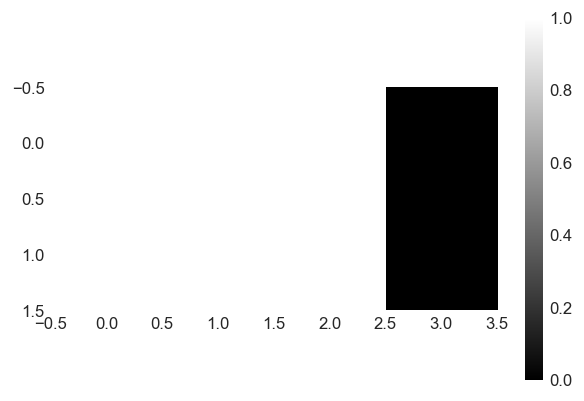

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.]])

In [11]:
cal_heatmap( x8, True )

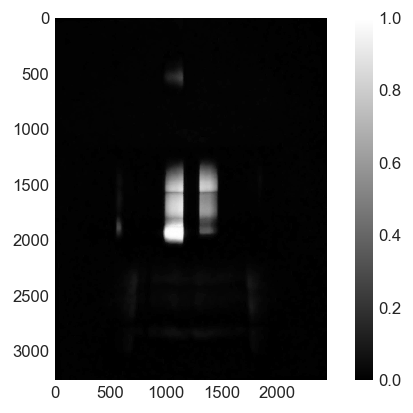

In [12]:
# try out the heat map function on the example image
hm = cal_heatmap( x_img, True )

## - 03 - function for correcting the alignment of the spectra

The PIL library is needed for rotating images. If PIL library is not available, you may manually correct the alignment and skip this step.

In [13]:
try:
    from PIL import Image
    PIL_imported = True
    print "PIL module imported."
except ImportError:
    PIL_imported = False
    print "PIL module not available. Cannot do spectra alignment."

PIL module imported.


In [14]:
def align_spec(img, n=0.5):
    if PIL_imported == False:
        raise RuntimeError( "PIL library not available." )
    else:
        pass
    
    xir = pp.imread( img )
    xr_img = xir.astype( float )/255.0
    hm_img = cal_heatmap( xr_img )
    
    x0 = hm_img.mean( axis=0 )
    x0 = x0/x0.max()
    x0thres = np.argwhere( x0 > n ).flatten()
    x1 = hm_img.mean( axis=1 )
    x1 = x1/x1.max()
    x1thres = np.argwhere( x1 > n ).flatten()
    
    xr_spc = xr_img[x1thres[0]:x1thres[-1], x0thres[0]:x0thres[-1], :]
    fig_out( xr_spc )
    
    a, b = input("Input the x-range of the edge (2 integers): ")
    fig_out( xr_spc[:, a:b, :] )
    p = raw_input( "Ok to proceed? (Y/n): " )
    if p=='N' or p=='n':
        return 0
    else:
        pass
    
    hmr_spc = cal_heatmap( xr_spc[:, a:b, :] )
    edge_x, edge_y = [], []
    for i in range( np.shape(hmr_spc)[0] ):
        edge = np.argwhere( hmr_spc[i,:] > 0.2 ).flatten()
        if len(edge)==0:
            print "No edge found."
        else:
            edge_x.append( edge[-1] )
            edge_y.append( i )
    edge_x = np.array(edge_x)
    edge_y = np.array(edge_y)
    k = np.polyfit( edge_x, edge_y, 1 )[0]
    
    img_ori = Image.open( img )
    img_crt = img_ori.rotate( math.atan(-1./k)*180./math.pi)
    img_crt.show()
    
    file_ID, file_ext = img.split('.')
    img_crt.save( file_ID+"_crt."+file_ext )
    print ( "Corrected image saved." )

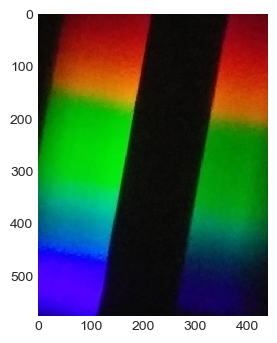

Input the x-range of the edge (2 integers): 100, 240


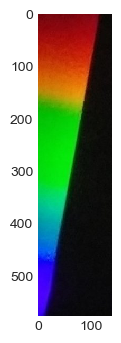

Ok to proceed? (Y/n): y
Corrected image saved.


In [15]:
img_file = "EOSpec01/EOS_imgs/example_spec_rot.jpg"
align_spec( img_file )

## - 04 - functions for finding the reference spectrum and saving calibration record

In [16]:
# x_hm: heat map as numpy array 
# fo: full output
# n: threshold as ratio of peak
# pf_check: check if the image is profile (rather than landscape)
# rt_check: rotation check 
# find_gap: find gap between ref. spec. and sam. spec., return gap=0 if False 

def find_ref( x_hm, fo=False, n=0.2, pf_check=True, rt_check=False, find_gap=False ):
    n = float( n )
    if n<0.1 or n>0.9:
        n = 0.2    # n should be between 0.1 and 0.9, otherwise set to 0.2
    else:
        pass
    
    h, w = x_hm.shape
    if h<w and pf_check==True:
        warnings.warn( "Input spectra image appears to be landscape." )
        proceed = raw_input( "Continue? (y/N): " )
        if proceed=='y' or proceed=='Y':
            pass
        else:
            raise RuntimeError( "Program terminated by user." )
    else:
        pass
    
    x0 = x_hm.mean( axis=0 )
    x0 = x0/x0.max()
    x0thres = np.argwhere( x0 > n ).flatten()
    x0diff  = x0thres[1:] - x0thres[:-1]
    x0gap   = np.where( x0diff > 2. )[0].flatten()
    gap = 0
    if len( x0gap )==0:
        if rt_check==True:
            fig_out( x_hm )
            rotate = raw_input( "Rotate image? (y/N): " )
            if rotate=='y' or rotate=='Y':
                raise RuntimeError( "Rotate image then restart program." )
            else:
                pass
        else:
            pass
        l_edge, r_edge = x0thres[0], x0thres[-1]
    else:
        if len(x0gap) > 1:
            fig_out( x_hm )
            trim = raw_input( "Trim image? (y/N): " )
            if rotate=='y' or rotate=='Y':
                raise RuntimeError( "Trim image then restart program." )
            else:
                pass
        else:
            l_edge, r_edge = x0thres[0], x0thres[ x0gap[0] ]

        if find_gap==True:
            gap = x0diff[ x0gap[0] ]
        else:
            pass
    
    x_hm_ref = x_hm[ :, l_edge:r_edge+1 ]
    x1 = x_hm_ref.mean( axis=1 )
    x1 = x1/x1.max()
    x1thres = np.argwhere( x1 > n ).flatten()
    t_edge, b_edge = x1thres[0], x1thres[-1]
    tblr_edge = ( t_edge, b_edge, l_edge, r_edge, gap )
    
    if fo==True:
        fig_out( x0, fig_dpi=120 )
        fig_out( x1, fig_dpi=120 )
    else:
        pass
    
    return tblr_edge

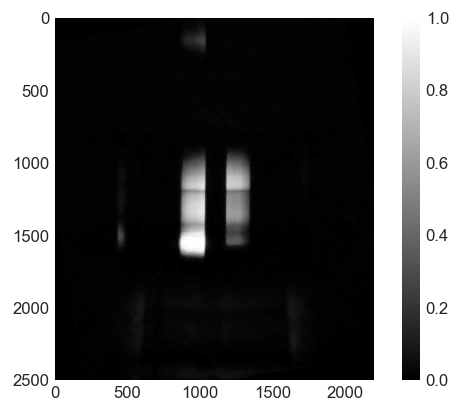

980 1650 862 1041 0


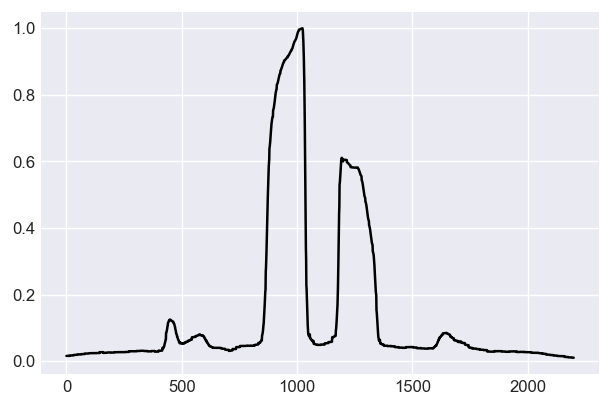

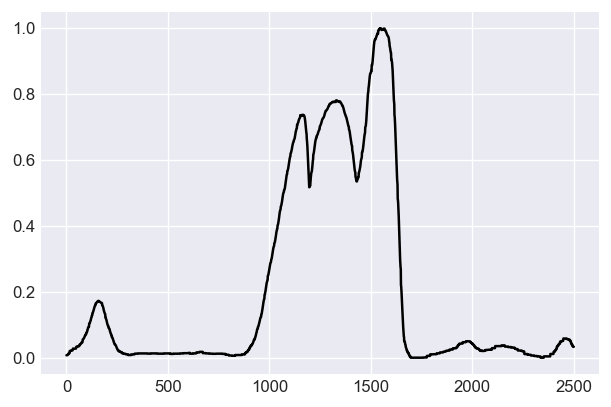

In [17]:
# try out the reference spectrum function
img_file = "EOSpec01/EOS_imgs/example_spec_rot_crt.jpg"
xi = pp.imread( img_file )
x_img = xi.astype( float )/255.0
hm = cal_heatmap( x_img, True )
top, btm, lft, rgt, gap = find_ref( hm, True )
print top, btm, lft, rgt, gap

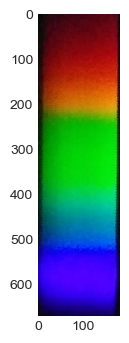

In [18]:
# check the reference spectrum found
fig_out( x_img[top:btm+1, lft:rgt+1, :] )

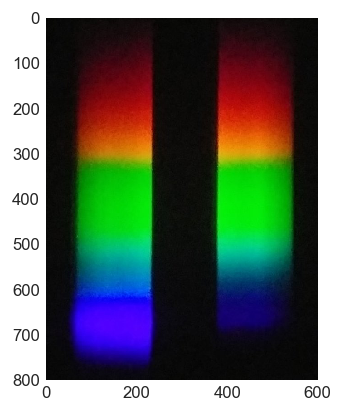

In [19]:
# use the blank test image to find gap
img_file = "EOSpec01/EOS_imgs/0mg.jpg"
x0i = pp.imread( img_file )
x0_img = x0i.astype( float )/255.0
fig_out( x0_img, 120 )

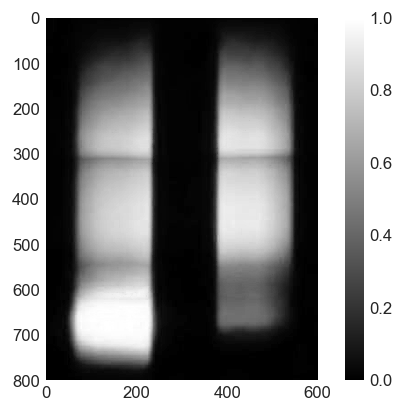

In [20]:
hm0 = cal_heatmap( x0_img, True )

96 765 61 238 136


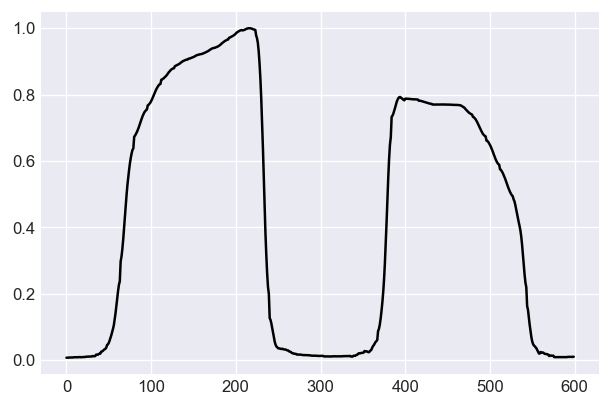

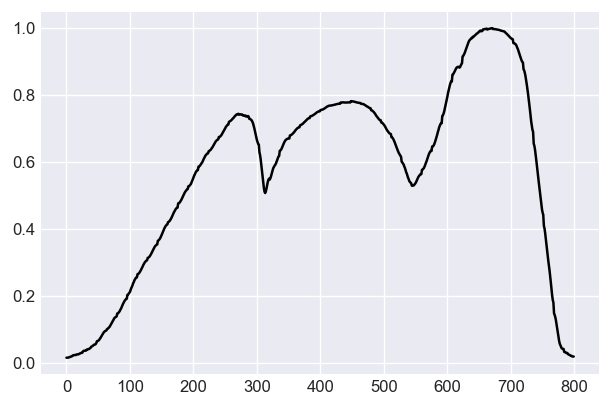

In [21]:
top0, btm0, lft0, rgt0, gap0 = find_ref( hm0, fo=True, find_gap=True )
print top0, btm0, lft0, rgt0, gap0

Gap (between ref. spec. and sam. spec.) is 136 pixels.

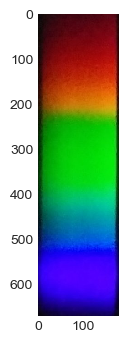

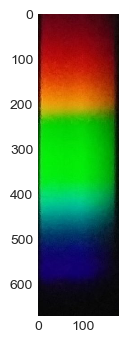

In [22]:
# check the reference spectrum and sample spectrum found
fig_out( x0_img[top0:btm0+1, lft0:rgt0+1, :] )
spec_wid = rgt0-lft0
fig_out( x0_img[top0:btm0+1, rgt0+gap0:rgt0+gap0+spec_wid+1, :] )

In [23]:
def save_cali( cali_file, gap=None, blank=None, kb=None ):
    f = open( cali_file, 'a+' )
    info = f.readlines()
    f.close()

    if len(info) == 0:
        info = ["gap, wavelength, intensity, k_fit, b_fit:\n", 
                "0\n",
                "0\n",
                "0\n",
                "0\n",
                "0\n"]
        
    if gap != None:
        info[1] = str( gap )+'\n'
    if blank != None:
        info[2] = str( blank[0] )+'\n'
        info[3] = str( blank[1] )+'\n'
    if kb != None:
        info[4] = str( kb[0] )+'\n'
        info[5] = str( kb[1] )+'\n'
        
    f = open( cali_file, 'w' )
    for i in range( len(info) ):
        f.write( info[i] )
    f.close()

In [24]:
# save the gap value to the calibration file
cali_file = "EOSpec01/calib.txt"
save_cali( cali_file, gap=gap0 )

## - 05 - function for normalizing the sample spectrum 

In [25]:
# x_img: input image as numpy array
# fo: full output
# csv_out: output the normalized sample spectrum found to csv file
# bpeak_chl: channel used to find blue peak, default to be 'r'
# trim_margin: trim margin of spectra by 1/10 on both (left & right) sides
# gap_input: allow manually input gap value if True
# peaks: wavelengths of the R and B peaks (in the bpeak_chl), need to know in advance.

def norm_sam( x_img, fo=False, csv_out=None, bpeak_chl='r', trim_margin=True, 
              gap_input=False, cali_file="EOSpec01/calib.txt", peaks=[610.65, 449.1] ):
    hm = cal_heatmap( x_img )
    t_edge, b_edge, l_edge, r_edge, gap = find_ref( hm )
        
    ref_wid = r_edge - l_edge
    if trim_margin == True:
        mrg = int( ref_wid/10. )
    else:
        mrg = 0
    half_hgt = int( (b_edge - t_edge)/2. )
    x_ref = x_img[ t_edge:b_edge, l_edge+mrg:r_edge-mrg, : ]
    y_ref = x_ref.mean( axis=1 )
    
    if bpeak_chl == 'r':
        peak_r = y_ref[:half_hgt,0].argmax()
        peak_b = y_ref[half_hgt:,0].argmax()+half_hgt
    else:
        peak_rgb = y_ref.argmax( axis=0 )
        peak_r, peak_b = peak_rgb[[0,2]]

    if gap_input==True:
        gap = input("Input the gap (integer): ")
    else:
        try:
            f = open( cali_file, 'r' )
            info = f.readlines()
            f.close()
        except IOError:
            raise RuntimeError( "Calibration file not found." )
        gap = int( info[1].strip() )
    
    x_sam = x_img[ t_edge:b_edge, r_edge+gap+mrg:r_edge+gap+ref_wid-mrg, : ]
    y_sam = x_sam.mean( axis=1 )
    max_rgb = y_ref.max( axis=0 )

    peak_px = np.array([peak_r, peak_b]).flatten()
    peak_nm = np.array( peaks )
    f = np.polyfit( peak_px, peak_nm, 1 )
    wavelength = np.arange(b_edge-t_edge)*f[0]+f[1]
    
    y_sam_norm_r = y_sam[:, 0]/max_rgb[0]
    y_sam_norm_g = y_sam[:, 1]/max_rgb[1]
    y_sam_norm_b = y_sam[:, 2]/max_rgb[2]
    y_sam_norm = np.dstack((y_sam_norm_r, y_sam_norm_g, y_sam_norm_b))[0]
    
    if csv_out != None:
        csv_file = open( csv_out, 'w' )
        csv_file.write("wavelength,sam_spec_norm_R,sam_spec_norm_G,sam_spec_norm_B\n")
        for i in range(len(wavelength)):
            csv_file.write( str(wavelength[i])+',' )
            csv_file.write( str(y_sam_norm_r[i])+',' )
            csv_file.write( str(y_sam_norm_g[i])+',' )
            csv_file.write( str(y_sam_norm_b[i])+'\n' )
        csv_file.close()
    else:
        pass
    
    if fo == True:
        return ((wavelength, y_sam_norm), (y_ref, y_sam), 
                (t_edge, b_edge, l_edge, r_edge, peak_r, peak_b, gap))
    else:
        return (wavelength, y_sam_norm)

In [26]:
# try out the sample spectrum function
full_result = norm_sam( x0_img, fo=True, csv_out="EOSpec01/output.csv" )
wv, sam_norm = full_result[0]
ref_raw, sam_raw = full_result[1]
other_result = full_result[2]

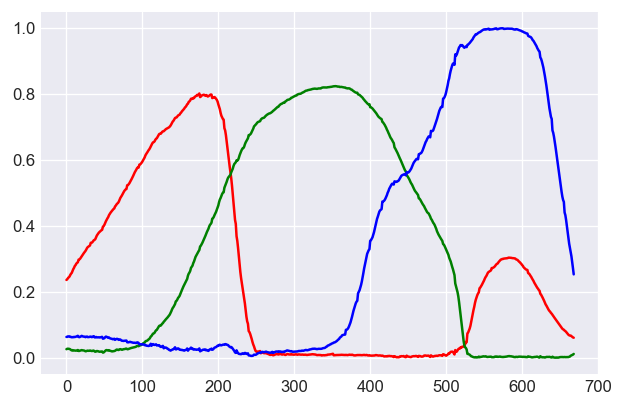

In [27]:
# check the reference spectrum (averaged)
fig_out( ref_raw, fig_dpi=120 )

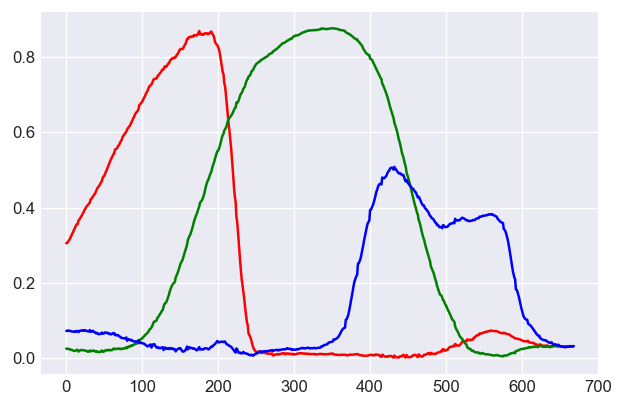

In [28]:
# check the sample spectrum (averaged) before normalization
fig_out( sam_raw, fig_dpi=120 )

Text(0,0.5,'normalized intensity')

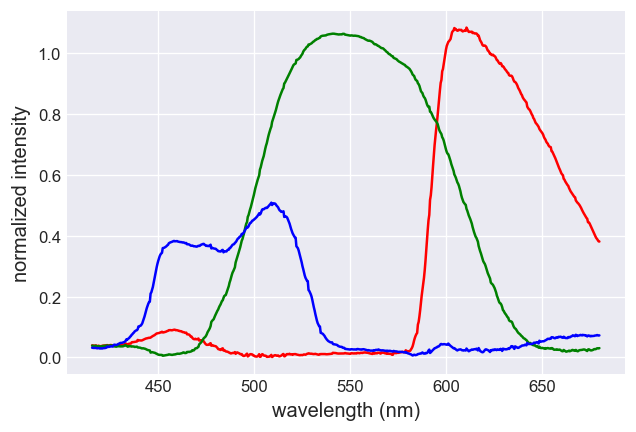

In [29]:
# check the normalized sample spectrum (averaged)
pp.figure( dpi=120 )
pp.style.use( "seaborn-darkgrid" )
pp.plot( wv, sam_norm[:,0], 'r-' )
pp.plot( wv, sam_norm[:,1], 'g-' )
pp.plot( wv, sam_norm[:,2], 'b-' )
pp.xlabel( "wavelength (nm)", size=12 )
pp.ylabel( "normalized intensity", size=12 )

## - 06 - function for calculating average intensity over a narrow band

In [30]:
# ifn: image file name
# ch: color channel
# wlc: wavelength range_center
# wlhs: wavelength range half span
# fo: full output

def cal_I( ifn, ch='g', wlc=530., wlhs=.5, fo=False ):
    wl_low, wl_high = wlc-wlhs, wlc+wlhs
    xi = pp.imread( ifn )
    x = xi.astype( float )/255.0
    wl_arr, sam_norm = norm_sam( x )
    
    if ch=='r' or ch=='R':
        y_arr = sam_norm[:,0]
    elif ch=='g' or ch=='G':
        y_arr = sam_norm[:,1]
    elif ch=='b' or ch=='B':
        y_arr = sam_norm[:,2]
    else:
        raise ValueError( "Color channel should be 'r', 'g', or 'b'." )
    
    arg_low = np.where( wl_arr < wl_high )[0][0]
    arg_high = np.where( wl_arr > wl_low )[0][-1]
    I_sum = y_arr[arg_low:arg_high+1].sum()
    I_ave = I_sum/(arg_high-arg_low+1)
    
    if fo == True:
        print wl_arr[arg_low:arg_high+1] 
        print y_arr[arg_low:arg_high+1]
        pp.figure( dpi=120 )
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( wl_arr, y_arr, 'k.-' )
        pp.xlabel( "wavelength (nm)", size=12 )
        pp.ylabel( "normalized intensity", size=12 )
    else:
        pass
    return I_ave

[539.77389706 539.37794118 538.98198529 538.58602941 538.19007353
 537.79411765 537.39816176 537.00220588 536.60625    536.21029412
 535.81433824 535.41838235 535.02242647 534.62647059 534.23051471
 533.83455882 533.43860294 533.04264706 532.64669118 532.25073529
 531.85477941 531.45882353 531.06286765 530.66691176 530.27095588]
[1.06378724 1.06362061 1.06282077 1.06242085 1.06152103 1.06095448
 1.05928814 1.0589882  1.05878824 1.058355   1.05795508 1.0578551
 1.0569886  1.05578884 1.05138972 1.05068986 1.04895688 1.04779044
 1.04769046 1.04489102 1.0439912  1.0414917  1.03945877 1.03812571
 1.03579284]


1.053176031460375

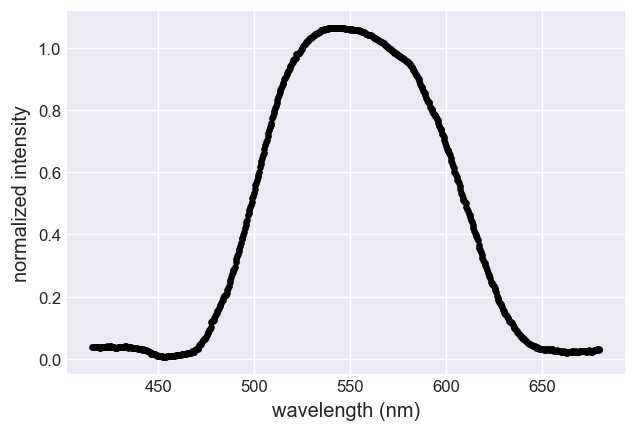

In [31]:
# try out the average intensity function
cal_I( img_file, ch='g', wlc=535., wlhs=5., fo=True )

[530.27095588 529.875     ]
[1.03579284 1.03322669]


1.034509764713725

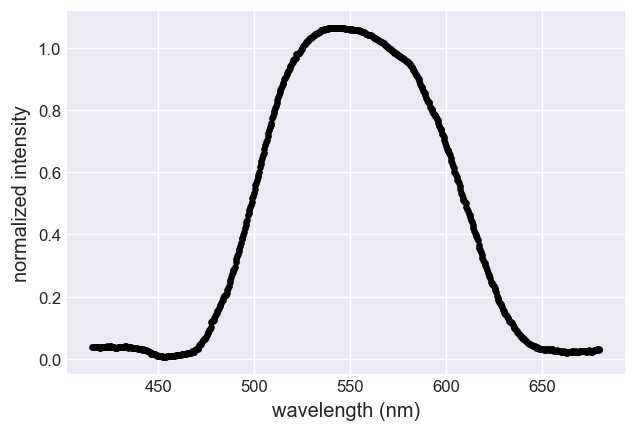

In [32]:
cal_I( img_file, ch='g', wlc=530., wlhs=.5, fo=True )

In [33]:
cali_file = "EOSpec01/calib.txt"
bk0 = [530.0, 1.034509764713725] 
save_cali( cali_file, blank=bk0 )

## - 07 - function for calibrating nitrate tests

In [34]:
# img_arr: a list/array of the image files
# nc_arr: a list/array of nitrate concentrations
# wl: wavelength of interest
# fo: figure output

def cali_N( img_arr, nc_arr, wl, cali_file="EOSpec01/calib.txt", fo=True ):
    if len(img_arr) != len(nc_arr):
        raise ValueError( "img_arr and nc_arr should have the same length." )
    else:
        pass
    nc = np.array(nc_arr)
    
    I_arr = []
    for img in img_arr:
        I_arr.append( cal_I( img, wlc=wl ) )
    I_arr = np.array( I_arr )
    
    f = open( cali_file, 'a+' )
    info = f.readlines()
    f.close()

    if len(info) == 0:
        raise RuntimeError( "Calibration file not found." )
    else: 
        bk_wv = float( info[2].strip() )
        bk_I = float( info[3].strip() )
        if abs(bk_wv-0.0) < 0.1:
            raise RuntimeError( "Blank calibration record missing." )
        elif abs(bk_wv-wl) > 0.5:
            raise RuntimeError( "Blank calibration wavelength mismatch." )
        else:
            I_norm = I_arr/bk_I
        
    lgI = np.log10( I_norm )   ## use Lg or log_10 for calculating absorbance 
    ## lgI = np.log( I_norm )  ## use ln or log_e for calculating absorbance 
    
    Ab = (-1.)*lgI
    kf, bf = np.polyfit( nc, Ab, 1 )
        
    if fo == True:
        pp.style.use( "seaborn-darkgrid" )
        pp.figure( dpi=120 )
        pp.plot( nc, Ab, 'k.', label="Calibration Data" )
        pp.plot( nc, nc*kf+bf, 'k-', label="Linear Fit" )
        pp.xlabel( "Nitrate Concentration (mg/L)", size=12)
        pp.ylabel( "Absorbance ("+str(wl-.5)+"nm $-$ "+str(wl+.5)+"nm)", size=12 )
        pp.legend( loc="upper left" )
    else:
        pass
    
    return ((kf, bf), nc, lgI)

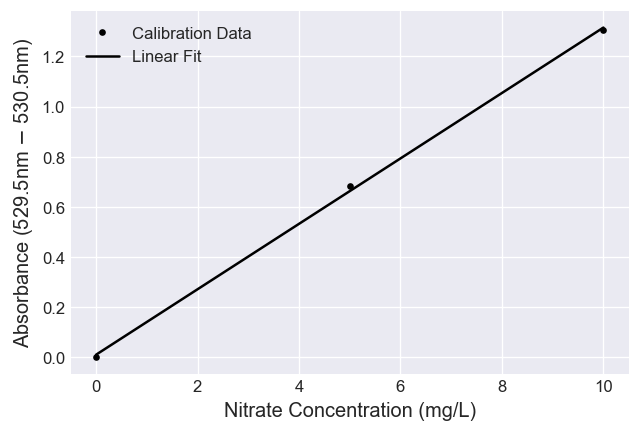

In [35]:
imgs = ["EOSpec01/EOS_imgs/0mg.jpg", 
        "EOSpec01/EOS_imgs/5mg.jpg", 
        "EOSpec01/EOS_imgs/10mg.jpg"]
ncs = [0.0, 5.0, 10.0]
kb_fit, nc, lgI = cali_N( imgs, ncs, 530. )

In [36]:
cali_file = "EOSpec01/calib.txt"
save_cali( cali_file, kb=kb_fit )

The k and b values varies a little bit with each individual EOS 1 device, so to ensure accuracy, a three-point calibration is highly recommended.

## - 08 - function for calculating nitrate concentration

In [37]:
# test_image: path and name of nitrate test image file
# wl: wavelength of interest

def test_N( test_image, wl=530., cali_file="EOSpec01/calib.txt" ):
    I = cal_I( test_image, wlc=wl )
    
    try:
        f = open( cali_file, 'r' )
        info = f.readlines()
        f.close()
    except IOError:
        print "Normalized Intensity: "+str(I)+'\n'
        raise RuntimeError( "Calibration file not found." )
    
    bk_wv = float( info[2].strip() )
    bk_I = float( info[3].strip() )
    if abs(bk_wv-0.0) < 0.1:
        raise RuntimeError( "Blank calibration record missing." )
    elif abs(bk_wv-wl) > 0.5:
        raise RuntimeError( "Blank calibration wavelength mismatch." )
    else:
        I_norm = I/bk_I
    lgI = np.log10(I)
    Ab = (-1.)*lgI
    
    k_fit = float( info[4].strip() )
    b_fit = float( info[5].strip() )
    if k_fit < 1e-5:
        raise RuntimeError( "Nitrate test calibration record missing." )
    else:
        nc = (Ab-b_fit)/k_fit
    
    print "Nitrate Concentration: "+str(round(nc, 2))+" mg/L"
    return nc

In [38]:
# try out the nitrate concentration function
img_file = "EOSpec01/EOS_imgs/example_spec_rot_crt.jpg"
test_N( img_file )

Nitrate Concentration: 1.3 mg/L


1.3017753805295134

Go to GitHub repo: https://github.com/jianshengfeng/EOS1 for updates.